In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
import torch.optim as optim
import os 
import random
from torch.utils.data import Dataset, DataLoader
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights, resnet18, ResNet18_Weights
from tqdm import tqdm
import pylab as pl
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageEnhance
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import shutil

In [ ]:
# Contar gatos y perros
# Ruta del directorio que contiene las imágenes
dataset_path = "../../../PetsDataset/images/images/"

# Obtener la lista de archivos en el directorio
files = os.listdir(dataset_path)

# Contadores para imágenes de gato y perro
count_cat = 0
count_dog = 0

# Iterar sobre los archivos
for file in files:
    # Verificar si el nombre del archivo comienza con mayúscula
    if file[0].isupper():
        count_cat += 1
    else:
        count_dog += 1

# Imprimir resultados
print(f"Total de imágenes de gato: {count_cat}")
print(f"Total de imágenes de perro: {count_dog}")

In [ ]:
# Sin data augmentation

# Ruta del directorio que contiene las imágenes
dataset_path = "../../../PetsDataset/images/images/"

# Crear directorios para train, validation y test
train_path = "train_dataset"
val_path = "val_dataset"
test_path = "test_dataset"

os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Obtener la lista de archivos en el directorio
files = os.listdir(dataset_path)

# Filtrar archivos de imágenes
image_files = [f for f in files if f.endswith('.jpg')]

# Mezclar las imágenes aleatoriamente
random.shuffle(image_files)

# Porcentaje de imágenes para cada conjunto
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Calcular el número de imágenes para cada conjunto
num_images = len(image_files)
num_train = int(train_ratio * num_images)
num_val = int(val_ratio * num_images)
num_test = num_images - num_train - num_val

# Dividir las imágenes en conjuntos
train_images = image_files[:num_train]
val_images = image_files[num_train:num_train + num_val]
test_images = image_files[num_train + num_val:]

# Mover imágenes a un directorio específico
def move_images(images, destination_path):
    moved_image_paths = []
    for img in images:
        src_path = os.path.join(dataset_path, img)
        dest_path = os.path.join(destination_path, img)
        shutil.copy(src_path, dest_path)
        moved_image_paths.append(dest_path)
    return moved_image_paths

# Mover imágenes a los directorios respectivos
train_images = move_images(train_images, train_path)
val_images = move_images(val_images, val_path)
test_images = move_images(test_images, test_path)

print(f"Total de imágenes de entrenamiento: {len(train_images)}")
print(f"Total de imágenes de validación: {len(val_images)}")
print(f"Total de imágenes de prueba: {len(test_images)}")

In [15]:
# Con data augmentation

# Ruta del directorio que contiene las imágenes
dataset_path = "../../../PetsDataset/images/images/"

# Crear directorios para train, validation y test
train_path = "train_dataset"
val_path = "val_dataset"
test_path = "test_dataset"

# Eliminar las carpetas si ya existen
if os.path.exists(train_path):
    shutil.rmtree(train_path)
if os.path.exists(val_path):
    shutil.rmtree(val_path)
if os.path.exists(test_path):
    shutil.rmtree(test_path)

os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Obtener la lista de archivos en el directorio
files = os.listdir(dataset_path)

# Filtrar archivos de imágenes
image_files = [f for f in files if f.endswith('.jpg')]

# Mezclar las imágenes aleatoriamente
random.shuffle(image_files)

# Porcentaje de imágenes para cada conjunto
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Calcular el número de imágenes para cada conjunto
num_images = len(image_files)
num_train = int(train_ratio * num_images)
num_val = int(val_ratio * num_images)
num_test = num_images - num_train - num_val

# Función para copiar y aplicar data augmentation a imágenes de entrenamiento de gatos
def copy_and_augment_images(images, destination_path):
    augmented_images = []  # Lista para almacenar las rutas de todas las imágenes (modificadas y no modificadas)

    for img in images:
        src_path = os.path.join(dataset_path, img)
        dest_path = os.path.join(destination_path, img)

        # Copiar la imagen original
        copy_image(src_path, dest_path)
        augmented_images.append(dest_path)  # Añadir la ruta de la imagen original a la lista

        # Aplicar data augmentation solo a las imágenes de entrenamiento que comienzan con mayúscula
        if destination_path == train_path and img[0].isupper() and os.path.exists(dest_path):
            # Obtener el nombre del archivo original sin la extensión
            base_name, ext = os.path.splitext(os.path.basename(dest_path))

            # Generar el nuevo nombre de archivo con la cadena "mod" y la extensión original
            new_name = f"{base_name}mod{ext}"

            # Construir la ruta completa para la imagen modificada
            augmented_image_path = os.path.join(destination_path, new_name)

            # Aplicar data augmentation solo si la imagen modificada no existe todavía
            if not os.path.exists(augmented_image_path):
                augment_and_save_image(dest_path)
                augmented_images.append(augmented_image_path)  # Añadir la ruta de la imagen modificada a la lista
    
    return augmented_images

# Función para copiar una imagen
def copy_image(src_path, dest_path):
    with open(src_path, 'rb') as src_file, open(dest_path, 'wb') as dest_file:
        dest_file.write(src_file.read())

# Función para aplicar data augmentation a una imagen y guardarla con un nuevo nombre
def augment_and_save_image(img_path):
    with Image.open(img_path) as image:
        # Aplicar ajuste de brillo
        image = image.convert("RGB")
        brightness_factor = 0.50 + random.uniform(0, 0.25)
        enhancer = ImageEnhance.Brightness(image)
        image = enhancer.enhance(brightness_factor)

        # Aplicar rotación
        image = image.transpose(Image.FLIP_LEFT_RIGHT)
        image = image.rotate(10)
        

        # Obtener el nombre del archivo original sin la extensión
        base_name, ext = os.path.splitext(os.path.basename(img_path))

        # Generar el nuevo nombre de archivo con la cadena "mod" y la extensión original
        new_name = f"{base_name}mod{ext}"

        # Construir la ruta completa para guardar la imagen modificada
        output_path = os.path.join(os.path.dirname(img_path), new_name)

        # Guardar la imagen modificada en la misma ruta con el nuevo nombre
        image.save(output_path)

# Copiar y aplicar data augmentation solo a las imágenes de entrenamiento
train_images = copy_and_augment_images(image_files[:num_train], train_path)
val_images = copy_and_augment_images(image_files[num_train:num_train + num_val], val_path)
test_images = copy_and_augment_images(image_files[num_train + num_val:], test_path)

# Contadores
total_train_images = 0
uppercase_train_images = 0
lowercase_train_images = 0

# Iterar sobre las imágenes de entrenamiento y contar
for img in train_images:
    total_train_images += 1

    # Verificar si la imagen comienza con mayúscula o minúscula
    if os.path.basename(img)[0].isupper():
        uppercase_train_images += 1
    else:
        lowercase_train_images += 1



print(f"Total de imágenes de entrenamiento: {num_train}")
print(f"Total de imágenes de validación: {num_val}")
print(f"Total de imágenes de prueba: {num_test}")

print(f"Total de imágenes de entrenamiento después del data augmentation: {total_train_images}")
print(f"Imágenes de entrenamiento de Gatos después del data augmentation: {uppercase_train_images}")
print(f"Imágenes de entrenamiento de Perros después del data augmentation: {lowercase_train_images}")

Total de imágenes de entrenamiento: 5173
Total de imágenes de validación: 1478
Total de imágenes de prueba: 739
Total de imágenes de entrenamiento después del data augmentation: 6849
Imágenes de entrenamiento de Gatos después del data augmentation: 3352
Imágenes de entrenamiento de Perros después del data augmentation: 3497


In [16]:
# Dataset sin normalizar
train_batch_size = 64
test_batch_size = 64

class PetDataset(Dataset):
    def __init__(self, images, transform=None):
        super().__init__()
        self.paths = images
        self.len = len(self.paths)
        self.transform = transform

    def __len__(self):
        return self.len
        
    
    def __getitem__(self, index):
        path = self.paths[index]
        image = Image.open(path).convert("RGB")
        if image is None:
            print(path)

        img_name = os.path.basename(path)
        label_img = 0 if img_name[0].isupper() else 1  # 0 para gato, 1 para perro
        
        image = self.transform(image)

        
        return (image, label_img)

# Definir las transformaciones
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Crear instancias de PetDataset con las transformaciones
train_data = PetDataset(train_images, transform=transform)
val_data = PetDataset(val_images, transform=transform)
test_data = PetDataset(test_images, transform=transform)

# Crear DataLoaders
train_loader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=test_batch_size)
test_loader = DataLoader(test_data, batch_size=test_batch_size)

In [ ]:
# Calcular la media y desviación de los datos
mean = 0.0
std = 0.0
num_channels = 0
num_samples = len(train_data)

# Calcula promedios acumulativos
for data, _ in tqdm(train_data, total=num_samples, desc="Calculando promedios"):
    mean += data.mean(dim=(1, 2))
    std += data.std(dim=(1, 2))
    num_channels += data.size(1)  # Añade el número de canales

# Calcula promedios finales dividiendo por el número total de canales
mean /= num_samples
std /= num_samples

print("Mean:", mean)
print("Std:", std)
# Mean: tensor([0.4289, 0.3993, 0.3530])
# Std: tensor([0.2099, 0.2063, 0.2070])

In [20]:
# Con normalización de las imágenes

train_batch_size = 64
test_batch_size = 64

class PetDataset(Dataset):
    def __init__(self, images, transform=None):
        super().__init__()
        self.paths = images
        self.len = len(self.paths)
        self.transform = transform

    def __len__(self):
        return self.len
        
    
    def __getitem__(self, index):
        path = self.paths[index]
        image = Image.open(path).convert("RGB")
        if image is None:
            print(path)

        img_name = os.path.basename(path)
        label_img = 0 if img_name[0].isupper() else 1  # 0 para gato, 1 para perro
        
        image = self.transform(image)

        
        return (image, label_img)

# Definir las transformaciones
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4289, 0.3993, 0.3530], std=[0.2099, 0.2063, 0.2070])
])

# Crear instancias de PetDataset con las transformaciones
train_data = PetDataset(train_images, transform=transform)
val_data = PetDataset(val_images, transform=transform)
test_data = PetDataset(test_images, transform=transform)

# Crear DataLoaders
train_loader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=test_batch_size)
test_loader = DataLoader(test_data, batch_size=test_batch_size)

In [ ]:
## Primera aproximación a mobileNetV1
## Se ha seguido el esquema de la red mobileNetV1 (https://paperswithcode.com/method/mobilenetv1) pero sin convoluciones profundas
class SimpleMobileNetV1(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleMobileNetV1, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            *[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1) for _ in range(5)],

            nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),

            nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),

            nn.AdaptiveAvgPool2d(1)
        )

        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

In [ ]:
## Se añade dropout
class SimpleMobileNetV1WithDropout(nn.Module):
    def __init__(self, num_classes=2, dropout_prob=0.5):
        super(SimpleMobileNetV1WithDropout, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            *[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1) for _ in range(5)],
            
            nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),

            nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),

            nn.AdaptiveAvgPool2d(1)
        )
        
        self.dropout = nn.Dropout(dropout_prob)

        self.fc = nn.Linear(1024, num_classes)


    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [31]:
## Se opta por crear un modelo CNN simple debido al bajo rendimiento de nuestro MobileNet
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2, dropout_prob=0.5):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 32 * 32, 128)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(128, num_classes)  # Output: 2 clases (perro, gato)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = x.view(-1, 128 * 32 * 32) # Aplanamos el tensor
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        
        return x

In [6]:
## Se añade una convolución
class SimpleCNNV2(nn.Module):
    def __init__(self, num_classes=2, dropout_prob=0.5):
        super(SimpleCNNV2, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256 * 16 * 16, 512)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(512, num_classes)  # Dos clases: perro y gato

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv4(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = x.view(-1, 256 * 16 * 16)  # Aplanamos el tensor

        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        
        return x

In [7]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(33)
if use_cuda:
    print("Using CUDA")
    device = torch.device("cuda")
else:
    print("Using CPU")
    device = torch.device("cpu")

Using CUDA


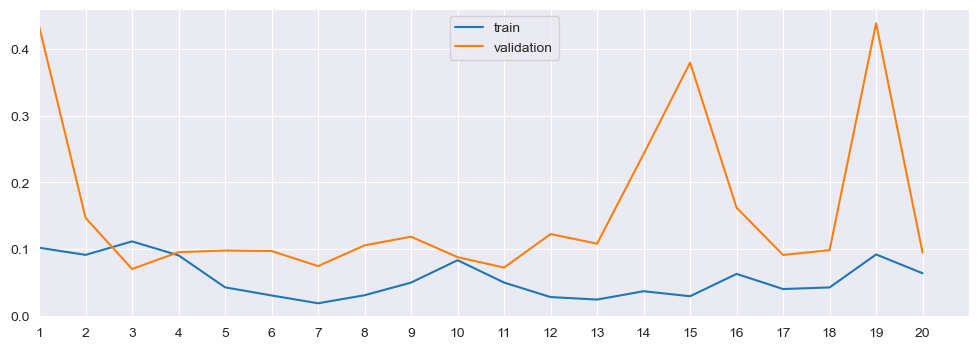

Epoch:20 Training Loss:0.06365411473584741 Validation Loss:0.09446271953250591 Accuracy: 0.9682002706359946: 100%|██████████| 20/20 [28:07<00:00, 84.38s/it]


In [27]:
# Entrenamiento
epochs = 20
lr =0.001
# model = SimpleMobileNetV1().to(device)
# model = SimpleMobileNetV1WithDropout().to(device)
# model = SimpleCNN().to(device)
# model = SimpleCNNV2().to(device)
# model = mobilenet_v2(weights=None).to(device)
model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1).to(device)

# Modificar la capa final para adaptarse a dos clases (gatos y perros)
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, 2).to(device)

# optimizer = optim.Adam(model.parameters(), lr=lr)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.001)
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

criterion = nn.CrossEntropyLoss()
trainloader = train_loader
valloader = val_loader

train_l = np.zeros((epochs))
test_l = np.zeros((epochs))

pbar = tqdm(range(1, epochs+1)) # tdqm permet tenir text dinàmic
best_accuracy = 0

for epoch in pbar:
    train_loss = 0
    test_loss = 0
    train_accuracy = 0
    test_accuracy = 0
    
    model.train()

    for batch_idx, (data, target) in enumerate(trainloader):
    
        data= data.to(device)
        target = target.to(device)
        
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()

    model.eval()
    
    targets = []
    predictions = []
    with torch.no_grad():
        for data, target in valloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)  # index amb la max probabilitat
            loss = criterion(output, target)
            test_loss += loss.item()
            targets.extend(target.tolist())
            predictions.extend(torch.flatten(pred.cpu()).tolist())
        
    targets = np.asarray(targets)
    predictions = np.asarray(predictions)

    test_accuracy = accuracy_score(targets, predictions)
            
    
    train_loss /= len(trainloader)
    train_l[epoch - 1] = train_loss
    
    test_loss /= len(valloader)
    test_l[epoch - 1] = test_loss
    
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_model = model
    
    # VISUALITZACIO DINAMICA
    pl.figure(figsize=(12, 4))
    pl.plot(train_l[:epoch], label="train")
    pl.plot(test_l[:epoch], label="validation")
    pl.legend()
    pl.xlim(0, epochs)
    pl.xticks(range(0,epochs,1),range(1,epochs+1,1))
    
    display.clear_output(wait=True)
    display.display(pl.gcf())
    pl.close()

    pbar.set_description(f"Epoch:{epoch} Training Loss:{train_loss} Validation Loss:{test_loss} Accuracy: {test_accuracy}")
    
pbar.close()


In [28]:
# Guardamos el mejor modelo
torch.save(best_model.state_dict(), "Final/Models/Experimento_9.pt")

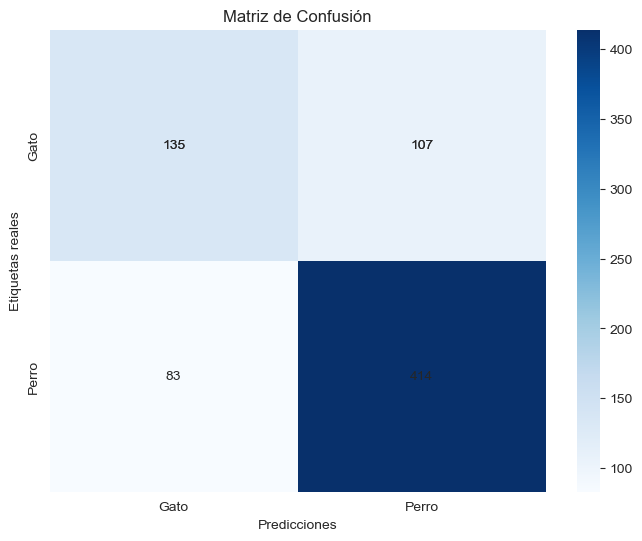

0.7428958051420839


In [32]:
# Obtener predicciones del mejor modelo en el conjunto de validación

# best_model = mobilenet_v2().to(device)
# in_features = best_model.classifier[1].in_features
# best_model.classifier[1] = nn.Linear(in_features, 2).to(device)

# best_model = SimpleCNNV2().to(device)
best_model = SimpleCNN().to(device)
# best_model = SimpleMobileNetV1().to(device)
best_model.load_state_dict(torch.load("Final/Models/Experimento_9.pt"))


best_model.eval()
with torch.no_grad():
    predictions = []
    ground_truth = []

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = best_model(data)
        predictions.extend(output.argmax(dim=1).cpu().numpy())
        ground_truth.extend(target.cpu().numpy())

# Convertir las predicciones y las etiquetas a listas de Python
predictions = np.array(predictions)
ground_truth = np.array(ground_truth)

# Calcular y mostrar la matriz de confusión
conf_matrix = confusion_matrix(ground_truth, predictions)
accuracy = accuracy_score(ground_truth, predictions)

# Etiquetas de clases
class_labels = ['Gato', 'Perro']

# Crear el gráfico de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

# Añadir el total por fila (suma de predicciones por clase)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j + 0.5, i + 0.5, str(conf_matrix[i, j]), ha='center', va='center')

plt.xlabel('Predicciones')
plt.ylabel('Etiquetas reales')
plt.title('Matriz de Confusión')
plt.show()
print(accuracy)
